### Federated Learning Unfair Size Split

In this notebook, we will train the same model (MobilenetV2) with the same federated learning algorythme but we will split the dataset in a unfair way so that their size will highly change but staying balanced

In [1]:
# This is for Kaggle notebook.
# import module we'll need to import our custom module
from shutil import copytree

# copy our file into the working directory (make sure it has .py suffix)
copytree(src = "../input/myfedprox/MyFedProx/", dst = "../working/MyFedProx")

'../working/MyFedProx'

In [2]:
from MyFedProx.CNN import CNN
from MyFedProx.federated_learning import *
from MyFedProx.dataset_splits import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
import numpy as np
from torchvision.models import mobilenet_v2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train_loader, test_loader = get_SIIM_ISIC("/kaggle/input/siim-isic-melanoma-classification/jpeg/train/", "/kaggle/input/siim-isic-melanoma-classification/train.csv",type="unfair_size", train_size=0.8, test_size=0.2, batch_size=32, device=device, total_size=None, resnet50=True, balanced=True)

<torch.utils.data.dataset.Subset object at 0x7d65e7962b30> <torch.utils.data.dataset.Subset object at 0x7d65e7962f50>


In [5]:
#Let's take a look at the class repartition in each clients
for i, loader in enumerate(train_loader):
    it = iter(loader)
    benign = 0
    malignant = 0
    for data, labels in it:
        for label in labels:
            if np.argmax(label.cpu()) == 1:
                malignant += 1
            else:
                benign += 1
    print(f"Client {i}:")
    print("Malignant: ", malignant)
    print("Benign: ", benign)
    print("Rate: ", malignant/(malignant+benign))

Client 0:
Malignant:  73
Benign:  83
Rate:  0.46794871794871795
Client 1:
Malignant:  229
Benign:  239
Rate:  0.4893162393162393
Client 2:
Malignant:  157
Benign:  154
Rate:  0.5048231511254019


All subsets are balanced but their size vary a lot

In [6]:
model = mobilenet_v2(pretrained=True).to(device)
model.classifier[1] = torch.nn.Linear(1280, 2).to(device)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
#model = CNN().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 174MB/s]


In [7]:
model, loss_acc, hist_acc = FedProx(model, train_loader,n_iter=10,  testing_sets=test_loader,  epochs=2, mu=0.3)

Clients' weights: [0.16684491978609625, 0.5005347593582887, 0.332620320855615]
====> i: 0 Loss: 0.7015228168212155 Server Test Accuracy: 55.867893782561794
====> i: 1 Loss: 0.48527549556232386 Server Test Accuracy: 70.67223612035528
====> i: 2 Loss: 0.4900701769851746 Server Test Accuracy: 70.45879139794818
====> i: 3 Loss: 0.45569937222781665 Server Test Accuracy: 73.17481811296504
====> i: 4 Loss: 0.45230423709288 Server Test Accuracy: 74.82086709049597
====> i: 5 Loss: 0.7166752910231524 Server Test Accuracy: 66.88210047967685
====> i: 6 Loss: 0.5663304852291862 Server Test Accuracy: 74.46466686557574
====> i: 7 Loss: 0.5054143435177318 Server Test Accuracy: 72.10116820821187
====> i: 8 Loss: 0.4612073825004904 Server Test Accuracy: 75.46808657134332
====> i: 9 Loss: 0.4798518752350527 Server Test Accuracy: 75.39464322599895
====> i: 10 Loss: 0.5507324254449039 Server Test Accuracy: 74.46420784466733


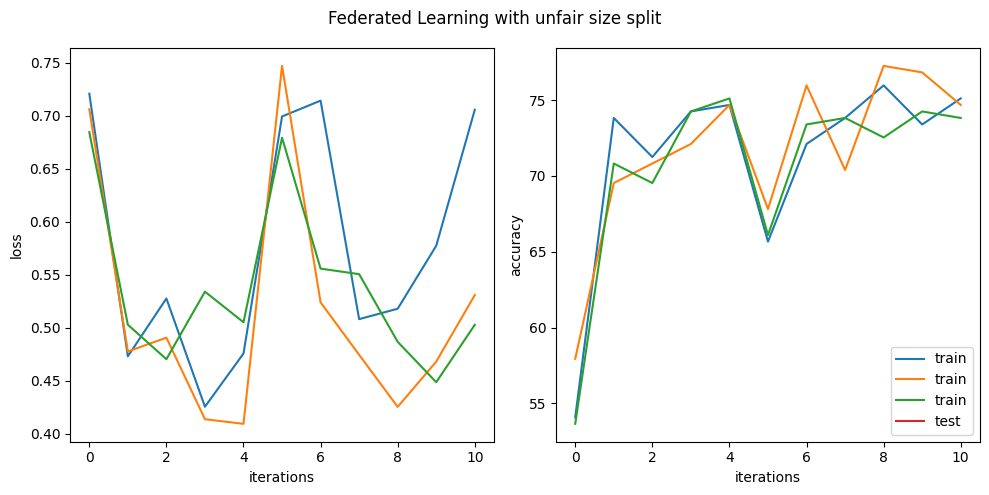

In [8]:
plot_acc_loss("Federated Learning with unfair size split", hist_acc, [], loss_acc)

We achieve a 75% test accuracy which is almost as good as the witness model

In [9]:
torch.save(model.state_dict(), "model_unfair_size_split.pt")